<div style="background-color:#e6ffe6; padding:10px; border-style:
solid;; border-color:#00e600; border-width:1px">

# AST4310 2023, Project 1

</div>

Authored by: *(15404)*.

In [1]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
from astropy import units
from astropy import constants as const
from astropy.modeling.models import BlackBody
from scipy.integrate import cumtrapz
from atoms import Atom

# Plot defaults and quantity support
from astropy.visualization import quantity_support
quantity_support()

plt.rcParams.update({
    'font.family': 'serif',
    'lines.markersize': 4,
    'lines.linewidth': 1,
    'figure.figsize': (6, 4)
})

<div style="background-color:#e6ffe6; padding:10px; border-style:
solid;; border-color:#00e600; border-width:1px">

### Exercise 1: Line formation in optically thick medium [30 points]
    
Assume an optically thick medium, where the Eddington-Barbier approximation is valid. A didactic tool to understand the formation of spectral lines is a diagram with four panels: total extinction vs. frequency (top left), optical depth vs height (top right), source function vs. height (bottom right), and emerging intensity vs. frequency (bottom left). It is also useful to plot the optical depth at two frequency points: near the maximum extinction and near the minimum extinction. 
    
In this exercise, you are to create such diagrams and explain in physical terms what is going on. The units are not important for these purposes, so feel free to use arbitrary units. You are free to create your own function for $\alpha(\nu)$ (extinction as a function of frequency), but keep in mind that spectral lines usually follow a Gaussian shape (or, more precisely, Voigt profile), and continua can usually be approximated by a line (for narrow wavelength regions). You are also free to select your own function for $S(h)$ (source function as a function of height). It is recommended that you do not set the extinction such that $\tau=1$ is reached at the edges of your height scale - some approximations will break down and strange things will follow. Assume that the extinction is the same at all height points (unrealistic, but simple for now).
    
* *[10 points]* Build $\alpha(\nu)$ and $S(h)$ such that the emergent intensity looks approximately like the plot below. Plot the 4-panel diagram and explain in physical terms the choices you made when building the extinction and source function. Would there be more than one way to build $\alpha$ and $S$ so that the resulting intensity would be the same?
    
<img src="https://tiagopereira.space/ast4310/images/intensity_plot1.svg" alt="Solar Ca II K and Halpha spectra" width="400"/>

* *[10 points]* Build $\alpha(\nu)$ and $S(h)$ such that the emergent intensity looks approximately like the plot below. Plot the 4-panel diagram and explain in physical terms the choices you made when building the extinction and source function. Would there be more than one way to build $\alpha$ and $S$ so that the resulting intensity would be the same?
    
<img src="https://tiagopereira.space/ast4310/images/intensity_plot2.svg" alt="Solar Ca II K and Halpha spectra" width="400"/>
    
* *[10 points]* Build $\alpha(\nu)$ and $S(h)$ such that you have a spectral line in absorption. Plot a modified version of the 4-panel diagram where the intensity plot you have both $I(\mu=1)$ and $I(\mu=0.2)$. Explain the differences between $I(\mu=1)$ and $I(\mu=0.2)$ using the information from the diagram.
    
</div>

I start with the extinction function, $\alpha(\nu)$. As this usually has a shape similar to the Gaussian, I will create a function that returns a Gaussian. In addition, the function should have the capability to return a Gaussian with multiple peaks, and a continuum with user-defined parameters.

In [2]:
def gaussian_profile(frequency, mult_peaks=False, baseline=0.1, slope=0.01, scale=100):
    '''
    Compute a Gaussian profile as function of frequency, on the form

        f(x) = a * exp(-x^2 / c) + continuum

    Parameters:
    ----------
    frequency : array_like 
        Array containing the frequencies.

    mult_peaks : bool, default=False 
        If set to True, a Gaussian profile with 3 peaks will be returned.

    baseline : float, default=0.1
        The continuum is considered to be on the form y = a + bx, where a is the baseline.

    slope : float, default=0.01
        Slope of the continuum (see baseline).

    scale : int or float, default=100
        The returned profile will be scaled down with this value, ie. if G is the Gaussian, the 
        returned value is G/scale.

    Returns:
    -------
    array_like
        The Gaussian profile with 1 or 3 peaks plus the baseline.
    '''
    cont = baseline + slope * frequency # Continuum

    # Selecting a, c depending on the number of peaks
    a, c = (1, 1) if not mult_peaks else (3, 0.2)

    exp1 = a * (np.exp(-frequency**2 / c) + cont) / scale
    exp2 = 0.3 * (np.exp(-(frequency - 2)**2 / 0.05) + cont) / scale
    exp3 = 0.1 * (np.exp(-(frequency - 3)**2 / 0.1) + cont) / scale
    
    profile = exp1 + exp2 + exp3 if mult_peaks else exp1

    return profile    

Next, I create a function to make the panels. Since the source function $S\nu)$ can have different forms, I add this to the function as well. 

In [3]:
def make_panels(profile_func='gaussian', source_func='gaussian', mult_mu=False, custom_pad=False):
    '''
    Create four panels for visualising the extinction, optical depth, intensity, and source function.

    Parameters:
    ----------
    profile_func : callable or tuple, optional
        The function describing the extinction profile. User can provide their own if they want.
        Default is the `gaussian_profile`. If a `tuple`, the elements are (bool, float, float, float),
        representing the arguments of the `gaussian_profile`.

    source_func : string, optional 
        Form of the source function. The two forms are:

            * 'gaussian' (default): Gaussian function on the form S(x) = exp[-(x - 500)^2 / (1.5*10^5)] + 0.65
            * 'linear': Linear function on the form S(x) = 2x / 100 + 0.65

    mult_mu : bool, default=False
        If True, the intensity panel will display two curves, one for mu = 1, and one for mu = 0.2

    custom_pad : ``bool`` default=``False``
        If true, a padding will be created for the figures to try and see the correlation
        between the scatters in the four panels.
    '''
    # Number of frequency elements.
    n = 101

    # Frequency from -5 to 5.
    freq = np.linspace(-5, 5, n)

    # Optical depth from 1 to 10^4 with 200 elements.
    # Height z is the negative height plus the highest depth.
    depth = np.logspace(0, 4, 200)
    z = -depth + depth.max()

    if callable(profile_func):
        profile = profile_func

    else:
        if profile_func == 'gaussian':
            profile = gaussian_profile(freq)

        elif isinstance(profile_func, tuple):
            mult_peaks, baseline, slope, scale = profile_func
            profile = gaussian_profile(
                freq,
                mult_peaks=mult_peaks,
                baseline=baseline,
                slope=slope,
                scale=scale
            )

    # Extinction and optical depth
    alpha = np.tile(profile, (len(z), 1))
    tau   = cumtrapz(alpha, -z, axis=0, initial=1e-3)

    # Get the indicies where tau = 1
    tau_z0    = np.argwhere(tau[:, 0] >= 1)[0]
    tau_zhalf = np.argwhere(tau[:, 50] >= 1)[0]

    # Source functions
    gauss = np.exp(-(depth - 500)**2 / 1.5e5) + 0.65
    lin   = 2 * depth / 100 + 0.65

    S_func = {
        'gaussian': gauss,
        'linear'  : lin
    }
    
    S = S_func[source_func]

    # Intensity
    I = np.trapz(S[:, np.newaxis] * np.exp(-tau), tau, axis=0)

    # Create the figure 
    fig, axes = plt.subplots(2, 2)
    ax1, ax2, ax3, ax4 = axes.flatten()

    ax1.set_title(r'Extinction $\alpha(\nu)$')
    ax1.plot(freq, alpha[0], color='black')
    ax1.plot(freq[0], alpha[0, 0], 'bo')
    ax1.plot(freq[50], alpha[0, 50], 'ro')

    ax2.set_title(r'Optical depth $\tau(z)$')
    ax2.plot(z, tau[:, 0], color='blue')
    ax2.plot(z, tau[:, 50], color='red')
    ax2.plot(z[tau_z0], 1, 'bo')
    ax2.plot(z[tau_zhalf], 1, 'ro')

    ax3.set_title(r'Intensity I$(\nu)$')
    ax3.plot(freq, I, color='black', label=r'I$(\mu=1)$')
    ax3.plot(freq[0], I[0], 'bo')
    ax3.plot(freq[50], I[50], 'ro')

    if mult_mu:
        I2 = np.trapz(S[:, np.newaxis] * np.exp(-tau / 0.2), tau, axis=0)
        ax3.plot(freq, I2, color='saddlebrown', label=r'I$(\mu=0.2)$')
        ax3.plot(freq[0], I2[0], 'bo')
        ax3.plot(freq[50], I2[50], 'ro')
        ax3.legend()
        print(f"\n{'':<6}S_nu(tau_nu=0.2) = {S[tau_z0][0]:.2f}, {S[tau_zhalf][0]:.2f}")
        print(f'I_nu(tau_nu=0, mu=0.2) = {I2[0]:5.2f}, {I2[50]:.2f}')  

    ax4.set_title(r'Source function $S(z)$')
    ax4.plot(z, S, color='black')
    ax4.plot(z[tau_z0], S[tau_z0], 'bo')
    ax4.plot(z[tau_zhalf], S[tau_zhalf], 'ro')
    
    if custom_pad:
        ax3.set_ylim(ax3.get_ylim()[0], np.max([I[0], I[50]]))
        ax4.set_ylim(ax4.get_ylim()[0], np.max([S[tau_z0], S[tau_zhalf]]))

        for ax in axes.flatten():
            pad = ax.get_ylim()[1] * 0.1
            ax.set_ylim(-pad, ax.get_ylim()[1] + pad)
            
    print(f"\n{'':<6}S_nu(tau_nu=1) = {S[tau_z0][0]:.2f}, {S[tau_zhalf][0]:.2f}")
    print(f'I_nu(tau_nu=0, mu=1) = {I[0]:.2f}, {I[50]:.2f}')
    fig.tight_layout()

This will now show the four panels, as shown below.


      S_nu(tau_nu=1) = 0.65, 0.98
I_nu(tau_nu=0, mu=1) = 0.90, 0.99


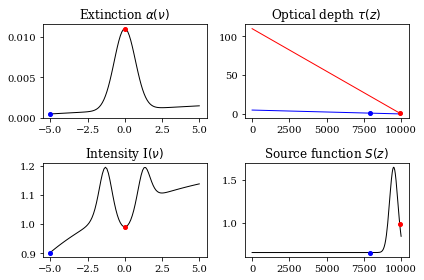

In [4]:
make_panels()

For the next figures, I will use a custom pad to show how the panels are connected.


      S_nu(tau_nu=1) = 30.64, 6.32
I_nu(tau_nu=0, mu=1) = 29.83, 6.11


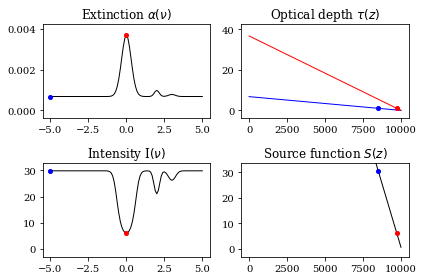

In [5]:
make_panels(profile_func=(True, 0.2, 0, 1000), source_func='linear', custom_pad=True)

Both of the above figures could have been created using different expressions for $\alpha$ and $S$. If for example the extinction function in the first figure would have been a flipped version of the intensity, A linear function for the source function would create the desired intensity. This is actually shown in the second figure, where I made the extinction to be the shape of the intensity, only upside down. 


      S_nu(tau_nu=0.2) = 10.99, 1.58
I_nu(tau_nu=0, mu=0.2) =  0.53, 0.17

      S_nu(tau_nu=1) = 10.99, 1.58
I_nu(tau_nu=0, mu=1) = 10.67, 1.58


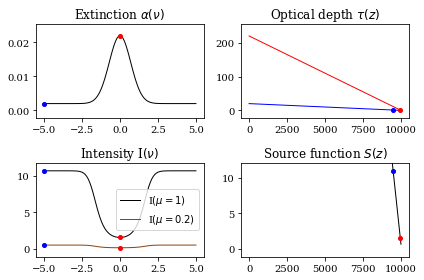

In [6]:
    make_panels(profile_func=(False, 0.1, 0, 50), source_func='linear', mult_mu=True, custom_pad=True)

In this figure, I have the spectral line in absorption. The intensity figure has two curves, one for $\mu=1$ (looking down vertically) and $\mu=0.2$ (oblique viewing).

For the $\mu=1$ case, the Eddington-Barbier (EB) approximation

\begin{align}
I^+_\nu(\tau'_\nu=0,\mu=1)\approx S_\nu(\tau'_\nu=1)
\end{align}

is actually exact, due to the fact that the source function varies linearly with optical depth. As seen from the output:
```
S_nu(tau_nu=1) = 10.99, 1.58
I_nu(tau_nu=0) = 10.67, 1.58
```
the EB approximation holds. 

Now, let's look at the case where $\mu=0.2$. Here, the BE approximation is given as

\begin{align}
I^+_\nu(\tau'_\nu=0,\mu)\approx S_\nu(\tau'_\nu=\mu)
\end{align}

As the radiation now is observed at an angle, the radiation from the surface at $\tau'_\nu=0$ is already at optical path length $\tau'_\nu=1$ from the surface, so we see the baseline of the intensity at a lower value for the $\mu=0.2$ curve, than for the $\mu=1$ curve. This also affects the center lobe of the line profile but does not continue past the lowest point of the source function, but rather flats out.

<div style="background-color:#e6ffe6; padding:10px; border-style:
solid;; border-color:#00e600; border-width:1px">

### Exercise 2: The Boltzmann and Saha laws [21 points]
    
An effective temperature around 9500 K is the classical divide between hot and cool stars, since it is approximately the temperature where hydrogen is 50% ionised. Hot stars have therefore mostly ionised hydrogen, and cool stars mostly neutral hydrogen.
    
* *[7 points]* Discuss what possible implications to the spectra of stars that come with hydrogen being ionised or neutral. 
* *[7 points]* Assuming that the Saha distribution can be applied, estimate what is the typical electron density in a star with effective temperature of 9500 K and a hydrogen ionisation fraction of 50%.
* *[7 points]* For the electron density you obtained before, plot the ionisation fraction of hydrogen as a function of temperature.
    
</div>

In the case of high-temperature stars, the hydrogen can become ionized. Electrons become free with higher energy, and when they fall back to lower energy states, they send out radiation in the Balmer series. These lines can be detected by observational instruments. In stars with lower temperatures, the hydrogen is mostly neutral. As the electrons are in lower energy states, the exerted radiation is also weaker. This radiation is in the Lyman series in the UV spectrum. 

The Saha distribution is given as 

\begin{align}
\left[\frac{N_{r+1}}{N_r}\right]^{TE}N_e=\frac{2U_{r+1}}{U_r}\left(\frac{2\pi m_ekT}{h^2}\right)^{3/2}e^{-\chi_r/kT},
\end{align}

where the fraction $N_{r+1}/N_r$ is the ratio between adjecent ionization levels, $N_e$ is the number density of electrons, and $U$ is the partition function for these  stages. For hydrogen, the total number of ionization stages $N=\sum_rN_r$ is equal to 1. The ionization fraction is $N_{r+1}/N=0.5$, which for hydrogen yields $N_{r+1}=0.5$. Now, I can solve the above equation with the ratio on the left-hand side equal to 1, for $N_e$:

\begin{align}
N_e&=\frac{2U_{r+1}}{U_r}\left(\frac{2\pi m_ekT}{h^2}\right)^{3/2}e^{-\chi_r/kT}
\end{align}

I will write a small function to calculate the electron number density for the specific case:

In [7]:
def compute_electron_density_hydrogen(temp):
    '''
    Calculate the number density of electrons when
    50 % ionized at a given temperature in Kelvin.

    Parameters
    ----------    
    temp : astropy.units.quantity.Quantity
        Temperature in Kelvin.

    Returns
    -------
    N_e : astropy.units.quantity.Quantity
        The number density in m^-3
    '''
    # Creating a local instance of the Atom class
    h = Atom('H_atom.txt')
    T = temp

    # Get the partition function for hydrogen
    U_0, U_1 = h.compute_partition_function(T)
    chi = h.chi_ion[1]

    # Define "Saha constant"
    SC = (2 * np.pi * const.m_e * const.k_B * T / (const.h**2))**(3/2)

    # Compute the electron density
    N_e = 2 * U_1 / U_0 * SC * np.exp(-chi / (const.k_B * T))

    # Fix unit and length 
    N_e = N_e.to('m-3')[0]

    return N_e    

In [8]:
T = 9500 * units.K
N_e = compute_electron_density_hydrogen(T)
N_e

<Quantity 1.36615772e+20 1 / m3>

I need the electron pressure $P_e$ to run with the `Atom` class. I'll use the formula $P_e=N_ek_BT$.

In [9]:
P_e = (N_e * const.k_B * T).to('Pa')
P_e

<Quantity 17.91875072 Pa>

Now I have all I need to plot the ionization fraction of hydrogen as a function of temperature.

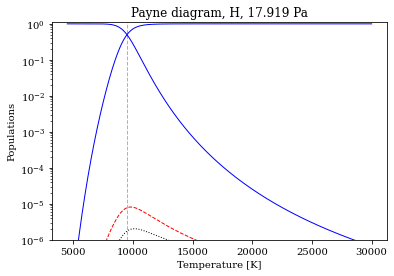

In [10]:
# Temperatures
temps = np.linspace(4.5e3, 3e4, 500) * units.K
h = Atom('H_atom.txt')
h.plot_payne(temps, P_e)
plt.title(f'Payne diagram, H, {P_e:.3f}')
plt.plot([9500, 9500], [1e-6, 1.1], 'k--', alpha=0.3);

Here, the blue line is the ground level $n=1$, the red dashed line is $n=2$, and the black dotted one is $n=3$. I also plotted the shaded line that represents the temperature of $9500\,\mathrm{K}$.

<div style="background-color:#e6ffe6; padding:10px; border-style:
solid;; border-color:#00e600; border-width:1px">

### Exercise 3: Magnesium [44 points]
    
Magnesium is a light element that is produced by nuclear fusion in massive stars. The so-called h & k lines are resonance lines of singly-ionised magnesium (Mg II) and have the wavelengths of 279.635 nm and 280.353 nm. These lines are some of the most important tracers of ionised gas in distant galaxies, in planetary nebulae and the interstellar medium of our own galaxy. They are also very useful diagnostics of the solar atmosphere, studied in great detail by [NASA's IRIS satellite](https://www.nasa.gov/mission_pages/iris/overview/index.html).
    
The provided file `MgI-III.txt` contains the energy levels of neutral and singly-ionised Mg, plus the ionisation energy of doubly-ionised Mg (Mg III). Use this file to answer this exercise.
    
* *[7 points]* What are the energies of the upper and lower levels for the Mg II h & k lines (relative to the Mg II ground state)?
* *[8 points]* Assuming Saha-Boltzmann statistics and an electron pressure of 1 kPa, what is the range of temperatures where Mg is mostly in the singly ionised form? Compare with hydrogen and discuss.
* *[10 points]* Making use of the [NIST Atomic Spectra Database Levels form](https://physics.nist.gov/PhysRefData/ASD/levels_form.html), extend the Mg atom file to include all ionisation stages up to (and including) Mg XI. Make a modified "Payne plot" to show only the strength of the ionisation stages as function of temperature for this new model atom. Plot for an electron pressure of 100 Pa and a range of temperatures between $3500$ and $2 \cdot 10^6$ K.
* *[9 points]* In diffuse media where densities are much lower, collisions are much less frequent and the Saha ionisation no longer applies. In these conditions, it is common to use the *Collisional Ionisation Equilibrium* (CIE), also called *coronal equilibrium* since it is a good approximation for the coronae of stars. The provided file `Mg_CIE.txt` contains the ionisation fractions of magnesium (up to Mg IX) as a function of temperature. Compare the ionisation fractions under CIE with the Saha (previous point) and discuss the differences. Which approximation is best on the surface of the Sun?
* *[10 points]* Discuss why under Collisional Ionisation Equilibrium, a bound-free transition can cool a gas, but the same is not true under Saha ionisation. 


</div>

I start with making an instance of the `Atom` class for the Mg I to Mg III.

In [11]:
mgi_iii = Atom('MgI-III.txt')

The h and k lines can be found by using the `logical_and` method from `numpy`. I convert from aJ to nm with `astropy`.

In [12]:
# Extract the second ionization stage of Mg, ie. Mg II
# and convert to units of nm
wave_aJ = mgi_iii.chi[1, :]
wave_nm = wave_aJ.to('nm', equivalencies=units.spectral())

# Get the index of the h and k lines
h_line_idx = np.logical_and(wave_nm.value >= 279.6, wave_nm.value <= 279.7)
k_line_idx = np.logical_and(wave_nm.value >= 280.3, wave_nm.value <= 2280.4)

# Get the energies for the h and k lines
h_line = wave_aJ[h_line_idx]
k_line = wave_aJ[k_line_idx]

print(f'h line energy: {h_line[0]:.3f}')
print(f'k line energy: {k_line[0]:.3f}')

h line energy: 0.710 aJ
k line energy: 0.709 aJ


/Users/johancarlsen/opt/anaconda3/lib/python3.9/site-packages/astropy/units/equivalencies.py:127: RuntimeWarning: divide by zero encountered in true_divide
  (si.m, si.J, lambda x: hc / x),


To find the temperature range where Mg is mostly in the singly ionized form, I plot the Payne diagram for Mg with $P_e=1\,\mathrm{kPa}$.

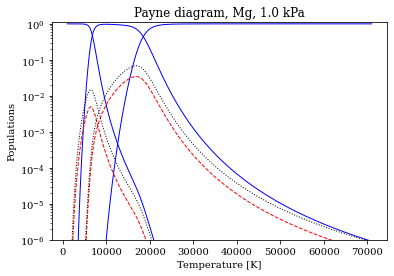

In [13]:
P_e = 1000 * units.Pa
temps = np.linspace(1e3, 7.1e4, 500) * units.K
mgi_iii.plot_payne(temps, P_e)
plt.title(f'Payne diagram, Mg, {P_e.to(units.kPa):.1f}');

The red dashed line represents the population of singly ionized Mg, ie. Mg II. Let's zoom in on the temperature range of interest.

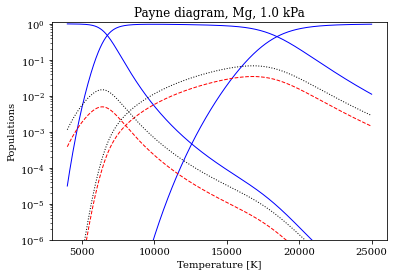

In [14]:
temps = np.linspace(4e3, 2.5e4, 500) * units.K
mgi_iii.plot_payne(temps, P_e)
plt.title(f'Payne diagram, Mg, {P_e.to(units.kPa):.1f}');

From the figure above, we see that the two maxima of the population for Mg II are located roughly between 5000 and 20000 K. Previously, I found that hydrogen at 17.919 Pa had the highest population of ionization at 9500 K. As the temperature around 10000 K is the temperature at which both hydrogen and magnesium are mostly singly ionized, these lines could be important lines when studying astronomical objects and their chemical composition.

For the next task, I have created the text file `MgI-XI`, which includes ionization stages up to Mg XI. 

In [15]:
mgi_xi = Atom('MgI-XI.txt')

To show only the ionization strength, I want the `Atom` class to not include the exitation. 

/Users/johancarlsen/opt/anaconda3/lib/python3.9/site-packages/astropy/units/quantity.py:486: RuntimeWarning: overflow encountered in exp
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/johancarlsen/opt/anaconda3/lib/python3.9/site-packages/astropy/units/quantity.py:486: RuntimeWarning: invalid value encountered in multiply
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


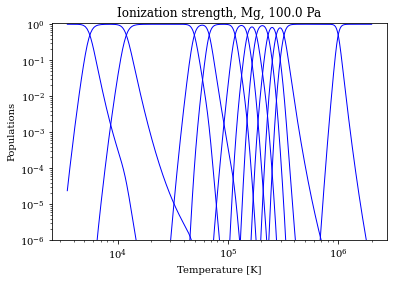

In [16]:
temps = np.linspace(3.5e3, 2e6, 10000) * units.K
P_e = 100 * units.Pa
mgi_xi.plot_payne(temps, P_e, compute_excitation=False)
plt.title(f'Ionization strength, Mg, {P_e}');

Above, I have plotted the ionization strength for Mg as a function of temperature. Each maximum represents the ionization population.

The file `Mg_CIE.txt` contains the temperature in the first column, and the ionization fractions in the remainding columns.

In [17]:
cie = np.loadtxt('Mg_CIE.txt')
temp, mg_cie = cie[:, 0], cie[:, 1:]

Making use of the `plot_payne` option of plotting the diagram on a given axis, I can plot both diagrams side by side.

/Users/johancarlsen/opt/anaconda3/lib/python3.9/site-packages/astropy/units/quantity.py:486: RuntimeWarning: overflow encountered in exp
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/johancarlsen/opt/anaconda3/lib/python3.9/site-packages/astropy/units/quantity.py:486: RuntimeWarning: invalid value encountered in multiply
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


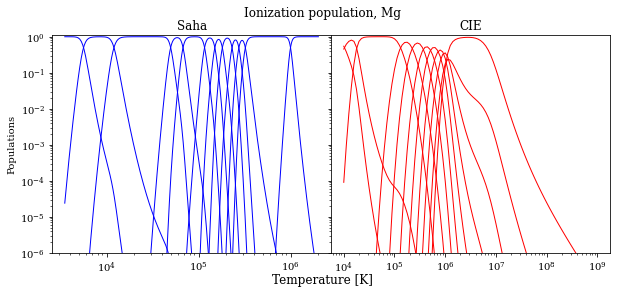

In [18]:
gs = dict(wspace=0)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4), sharey=True, gridspec_kw=gs)
fig.suptitle('Ionization population, Mg')

mgi_xi.plot_payne(temps, P_e, compute_excitation=False, ax=ax1)
ax1.set_title('Saha')
ax1.set_xlabel('')

ax2.set_title('CIE')
ax2.plot(temp, mg_cie, 'r')
ax2.set_xscale('log')
ax2.set_yscale('log')
ax2.set_ylim(1e-6, 1.1)

fig.supxlabel('Temperature [K]');

This figure shows how the ionization under CIE require much higher temperatures than under Saha. Also, the Mg IV to Mg X is seen to have lower population for CIE. At the solar surface, the density is much higher than in the corona, which means that the Saha equation is a better approximation than the CIE. 

Under CIE, equilibrium between ionized and neutral atoms are maintained through collisions. A neutral atom can be ionized through collision, which can cause the gas to loose heat through radiation. This is not the case for Saha statistics. Here, the number of neutral and ionized atoms are constant, meaning that there are no extra free elactrons that can contribute to temperature change. Hence, only under CIE can the gas be cooled from a bound-free transition.